Este notebook utiliza base de dados previamente preparada a partir da base lista5:

/content/drive/MyDrive/Colab Notebooks/DNC/Projeto TAG2u/trabalho/03 data preparation/base_modelagem_100823.csv

# Instalação de biblioteca

#Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from unidecode import unidecode

from pprint import pprint

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold
#from fast_ml.model_development import train_valid_test_split

import statsmodels.formula.api as smf #metodo de seleção de variaveis

from sklearn import metrics
from sklearn.metrics import r2_score,make_scorer, mean_absolute_error, mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split


from sklearn.feature_selection import SelectFromModel

import yellowbrick




#Criando Dataframe

In [2]:
# Importing the dataset(Dataframe creation)

# Importing the dataset(Dataframe creation)
df_original = pd.read_excel('C:\\Users\\carlo\\OneDrive\\git-repositorios\\tag2u\\e-commerce\\pipelines\\base_dados\\DNC Lista 5.xlsx')
df =df_original.copy()

In [3]:
df.head(5)

,datavenda,valor da venda,valorindividual,quantidade,valormercado,datapublicacao,material_predominante,material_secundario,Material não padronizado,cor,Categoria,titulo,altura,largura,profundidade,SKU
0,2022-07-13 18:52:58.763,250.0,250.0,1,250.0,2022-06-30 12:39:31.266,Couro Ecológico,Metal,Couro ecológico,NaN,Cadeira de Escritório,Cadeira de Escritório,110,68,60,4dec223b
1,2022-11-26 18:22:19.756,44.8,56.0,1,140.0,2022-09-14 17:25:00.220,MDP,NaN,NaN,Preto,Mesa de Telefone,Mesa de Telefone,60,35,35,04b7370f
2,2022-11-26 18:22:19.756,31.2,39.0,1,130.0,2022-08-31 14:02:21.980,MDP,NaN,MDF,Marrom,Aparador,Aparador,71,33,29,1bedb7af
3,2022-09-30 15:49:24.472,420.0,420.0,1,600.0,2022-08-30 11:34:25.956,Aço,NaN,Metal,Cinza,Arquivo,Arquivo c/ 4 Gavetas,137,147,60,e53fa86d
4,2022-07-12 03:00:00.000,144.0,144.0,1,180.0,2022-06-14 10:51:30.198,Metal,NaN,Plástico,Preto,Aparelho de Som,Aparelho de Som,23,41,24,ce7f5ade


Convertendo todos os dados dos dataframes para minusculo e retirando os acentos

In [3]:
# Lista das colunas no dataframe df que não são nem numéricas nem datas
colunas_nao_numericas_nem_datas = []

# Percorrer as colunas do dataframe
for coluna in df.columns:
    if not pd.api.types.is_numeric_dtype(df[coluna]) and not pd.api.types.is_datetime64_any_dtype(df[coluna]):
        colunas_nao_numericas_nem_datas.append(coluna)

# Exibir as colunas que não são numéricas, nem datas no dataframe df.
print(colunas_nao_numericas_nem_datas)

['material_predominante', 'material_secundario', 'Material não padronizado', 'cor', 'Categoria', 'titulo', 'altura', 'largura', 'profundidade', 'SKU']


In [4]:
# Conversão no dataframe df
# Converter todas as colunas salvas em colunas_nao_numericas_nem_datas para minúsculas e remover acentos
for coluna in colunas_nao_numericas_nem_datas:
    df[coluna] = df[coluna].apply(lambda x: unidecode(str(x).lower()) if pd.notnull(x) else np.nan)

In [19]:
# aplicamos acima a função unidecode() diretamente aos valores de cada célula, dentro de uma função lambda.
#Primeiro, convertemos o valor para minúsculas usando lower(), em seguida, removemos os acentos usando unidecode().
#No entanto, antes de aplicar a função, verificamos se o valor não é nulo usando pd.notnull(x).
#Se o valor for nulo, o próprio valor NaN será preservado.

Eliminando os espaços em branco no início e final de todas as strings em todas as colunas do DataFrame.

In [5]:
# Função para eliminar espaços em branco no início e final de todas as strings no DataFrame
def eliminar_espacos(row):
    return row.apply(lambda x: x.strip() if isinstance(x, str) else x)

# Aplicar a função em todo o DataFrame
df = df.apply(eliminar_espacos)

In [6]:
# Função para substituir strings de acordo com os padrões fornecidos
def replace_strings(text):
    if isinstance(text, str):
        # Converter a string para minúsculas
        text = text.lower()
        # Padrão: ( / ) -> _
        text = re.sub(r'\s/\s', '_', text)
        # Padrão: palavra/palavra -> palavra_palavra
        text = re.sub(r'(\w+)\s?/\s?(\w+)', r'\1_\2', text, flags=re.IGNORECASE)
        # Padrão: ( ler observacoes ) balcao -> balcao
        text = re.sub(r'\( ler observacoes \)\s', '', text)
        # Padrão: palavra palavra -> palavra_palavra
        text = re.sub(r'(\w+)\s(\w+)', r'\1_\2', text)
        # Padrão: 100% palavra -> palavra
        text = re.sub(r'100%\s(\w+)', r'\1', text)
        # Remover espaços em branco adicionais
        text = text.replace(" ", "_")
    return text

# Aplicar a função replace_strings para todas as células do DataFrame para substituir strings de acordo com os padrões fornecidos

#df = df.applymap(replace_strings)
df = df.map(replace_strings)


In [7]:
# Converter os nomes das colunas para letras minúsculas
df.columns = df.columns.str.lower()

# Remover acentos dos nomes das colunas
df.columns = [unidecode(col) for col in df.columns]

In [22]:
df

,datavenda,valor da venda,valorindividual,quantidade,valormercado,datapublicacao,material_predominante,material_secundario,material nao padronizado,cor,categoria,titulo,altura,largura,profundidade,sku
0,2022-07-13 18:52:58.763,250.0,250.0,1,250.0,2022-06-30 12:39:31.266,couro_ecologico,metal,couro_ecologico,NaN,cadeira_de_escritorio,cadeira_de_escritorio,110,68,60,4dec223b
1,2022-11-26 18:22:19.756,44.8,56.0,1,140.0,2022-09-14 17:25:00.220,mdp,NaN,NaN,preto,mesa_de_telefone,mesa_de_telefone,60,35,35,04b7370f
2,2022-11-26 18:22:19.756,31.2,39.0,1,130.0,2022-08-31 14:02:21.980,mdp,NaN,mdf,marrom,aparador,aparador,71,33,29,1bedb7af
3,2022-09-30 15:49:24.472,420.0,420.0,1,600.0,2022-08-30 11:34:25.956,aco,NaN,metal,cinza,arquivo,arquivo_c_4_gavetas,137,147,60,e53fa86d
4,2022-07-12 03:00:00.000,144.0,144.0,1,180.0,2022-06-14 10:51:30.198,metal,NaN,plastico,preto,aparelho_de_som,aparelho_de_som,23,41,24,ce7f5ade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,2023-07-20 18:34:07.949,180.0,180.0,1,200.0,2023-06-29 18:52:43.538,metal,NaN,metal,branco,microondas,microondas_20_litros,30,48,35,532999a4
42096,2023-07-20 19:19:31.184,188.0,188.0,1,150.0,2023-07-12 18:41:00.660,madeira,mdf,mdf,NaN,sapateira,sapateira_c_3_prateleiras,78,46,30,f3d3a11f
42097,2023-07-21 18:27:59.819,150.0,150.0,1,100.0,2023-07-21 17:02:17.493,couro_ecologico,NaN,vidro,NaN,espelho,espelho_c_moldura,51,51,4,4ed6fbe0
42098,2023-07-21 20:17:43.042,90.0,90.0,1,60.0,2023-07-19 20:28:17.144,ceramica,NaN,ceramica,amarelo,vaso,vaso,22,16,11,ac65d5a0


# Data Cleaning

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   datavenda                 42100 non-null  datetime64[ns]
 1   valor da venda            41972 non-null  float64       
 2   valorindividual           42100 non-null  float64       
 3   quantidade                42100 non-null  int64         
 4   valormercado              42100 non-null  float64       
 5   datapublicacao            41683 non-null  datetime64[ns]
 6   material_predominante     38943 non-null  object        
 7   material_secundario       5267 non-null   object        
 8   material nao padronizado  38468 non-null  object        
 9   cor                       40943 non-null  object        
 10  categoria                 42100 non-null  object        
 11  titulo                    42099 non-null  object        
 12  altura            

In [8]:
# Copiando o Dataframe df para df1
df1 = df.copy()

In [9]:
#Dropando colunas não necessárias para o modelo
colunas_para_dropar = ['valor da venda', 'valormercado', 'quantidade', 'datapublicacao', 'datavenda', 'material_secundario', 'material nao padronizado', 'sku', 'titulo']
df1.drop(colunas_para_dropar, axis=1, inplace=True)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   valorindividual        42100 non-null  float64
 1   material_predominante  38943 non-null  object 
 2   cor                    40943 non-null  object 
 3   categoria              42100 non-null  object 
 4   altura                 41971 non-null  object 
 5   largura                41953 non-null  object 
 6   profundidade           41542 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.2+ MB


In [10]:
# Remover valores nulos
df1 = df1.dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37433 entries, 1 to 42099
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   valorindividual        37433 non-null  float64
 1   material_predominante  37433 non-null  object 
 2   cor                    37433 non-null  object 
 3   categoria              37433 non-null  object 
 4   altura                 37433 non-null  object 
 5   largura                37433 non-null  object 
 6   profundidade           37433 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.3+ MB


In [11]:
# Remover valores duplicados
df1 = df1.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31674 entries, 0 to 31673
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   valorindividual        31674 non-null  float64
 1   material_predominante  31674 non-null  object 
 2   cor                    31674 non-null  object 
 3   categoria              31674 non-null  object 
 4   altura                 31674 non-null  object 
 5   largura                31674 non-null  object 
 6   profundidade           31674 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.7+ MB


Renomeando nomes de colunas

In [12]:
df1.rename(columns ={
    'valorindividual':'valor_individual',
    'material_predominante': 'material',
    
    }, inplace=True)

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31674 entries, 0 to 31673
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_individual  31674 non-null  float64
 1   material          31674 non-null  object 
 2   cor               31674 non-null  object 
 3   categoria         31674 non-null  object 
 4   altura            31674 non-null  object 
 5   largura           31674 non-null  object 
 6   profundidade      31674 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.7+ MB


Tratamento das colunas altura, largura e profundidade.

In [13]:
# Função para remover caracteres não numéricos e converter para int
def clean_numeric_to_int(value):
    if isinstance(value, str):
        numeric_value = re.sub(r"[^\d.]+", "", value)
        try:
            return int(numeric_value)
        except ValueError:
            return None
    else:
        return value

# Aplicar a função de limpeza nas colunas do DataFrame
df1["altura"] = df1["altura"].apply(clean_numeric_to_int)
df1["largura"] = df1["largura"].apply(clean_numeric_to_int)
df1["profundidade"] = df1["profundidade"].apply(clean_numeric_to_int)


In [33]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31674 entries, 0 to 31673
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_individual  31674 non-null  float64
 1   material          31674 non-null  object 
 2   cor               31674 non-null  object 
 3   categoria         31674 non-null  object 
 4   altura            30876 non-null  float64
 5   largura           30888 non-null  float64
 6   profundidade      30944 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.7+ MB


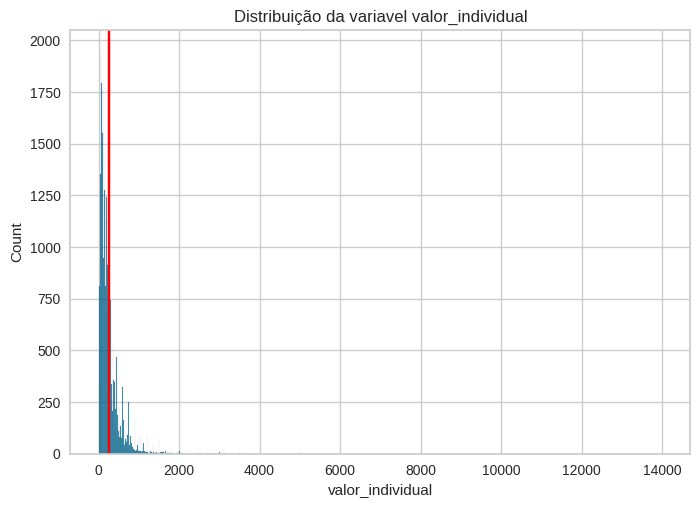

In [35]:
# análise gráfica-> dados quantitativos contínuos

sns.histplot(df1['valor_individual'])
plt.axvline(df1['valor_individual'].mean(), color='red', label='média')

plt.title('Distribuição da variavel valor_individual')
plt.show()

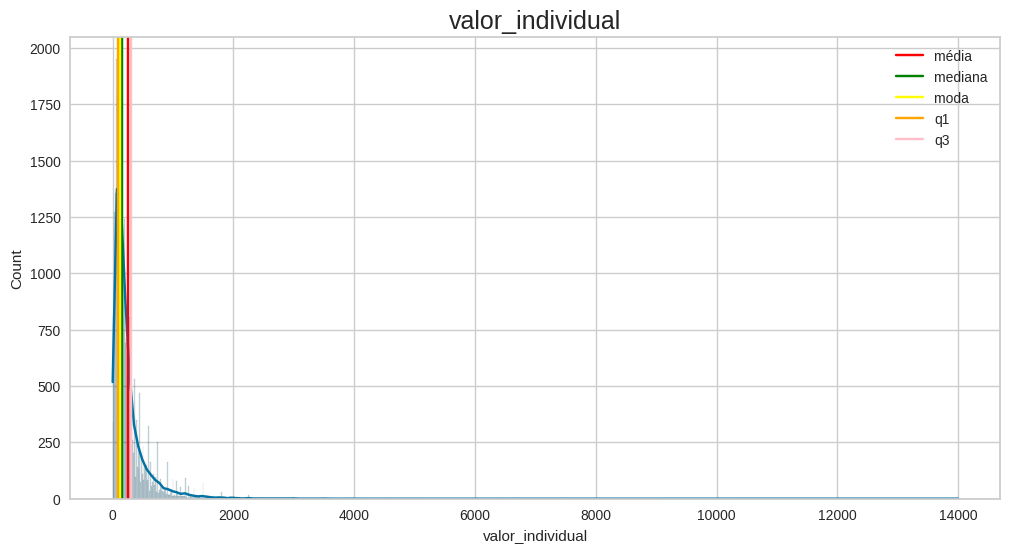

In [36]:
# Valor individual


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("valor_individual", size=18)

# Plot do Histograma
sns.histplot(df1["valor_individual"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1["valor_individual"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1["valor_individual"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1["valor_individual"].mode().shape[0]):
    plt.axvline(df1["valor_individual"].mode()[i], color="yellow", label="moda")

plt.axvline(df1["valor_individual"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1["valor_individual"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

In [37]:
percentiles = [0.9, 0.92, 0.94, 0.95, 0.96, 0.98]
df1.describe(percentiles= percentiles)

,valor_individual,valor_mercado,altura,largura,profundidade
count,31800.000000,31800.000000,30998.000000,3.100700e+04,3.106400e+04
mean,258.122846,261.661749,115.876799,1.348894e+02,4.002952e+03
std,329.541628,328.753779,4837.293770,6.815808e+03,6.922265e+05
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,160.000000,160.000000,77.000000,7.200000e+01,4.900000e+01
90%,581.000000,552.000000,170.000000,1.850000e+02,1.040000e+02
92%,645.000000,606.000000,182.000000,1.980000e+02,1.220000e+02
94%,750.000000,738.000000,195.000000,2.050000e+02,1.500000e+02
95%,810.000000,800.000000,200.000000,2.170000e+02,1.700000e+02
96%,900.000000,882.000000,207.120000,2.290000e+02,1.880000e+02


In [34]:
print('Media de valor individual = ',df1['valor_individual'].mean())
print('Mediana de valor individual = ',df1['valor_individual'].median())
print('Moda de valor individual = ',df1['valor_individual'].mode())

Media de valor individual =  258.24073340910525
Mediana de valor individual =  160.0
Moda de valor individual =  0    120.0
Name: valor_individual, dtype: float64


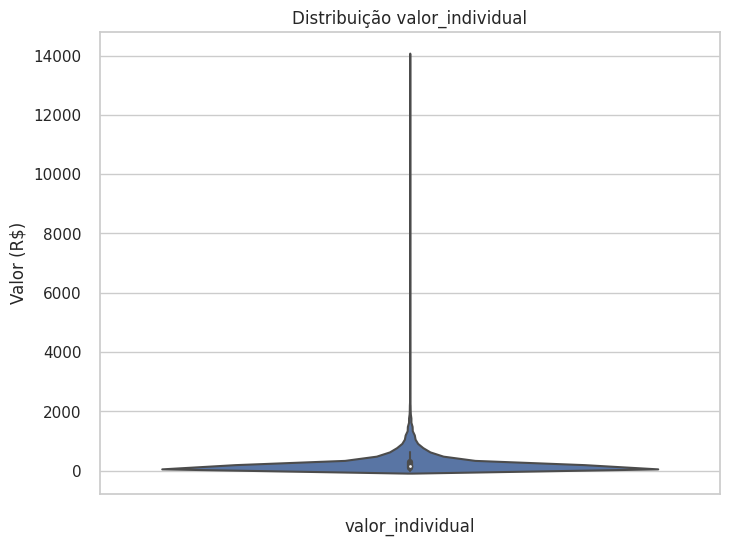

In [39]:
# Criação do gráfico de violino
sns.set(style="whitegrid")  # Estilo do gráfico

plt.figure(figsize=(8, 6))  # Tamanho da figura
sns.violinplot(y="valor_individual", data=df1)  # Dados a serem plotados

# Adicione títulos e rótulos
plt.title("Distribuição valor_individual")
plt.xlabel("valor_individual")
plt.ylabel("Valor (R$)")

# Exibir o gráfico
plt.show()

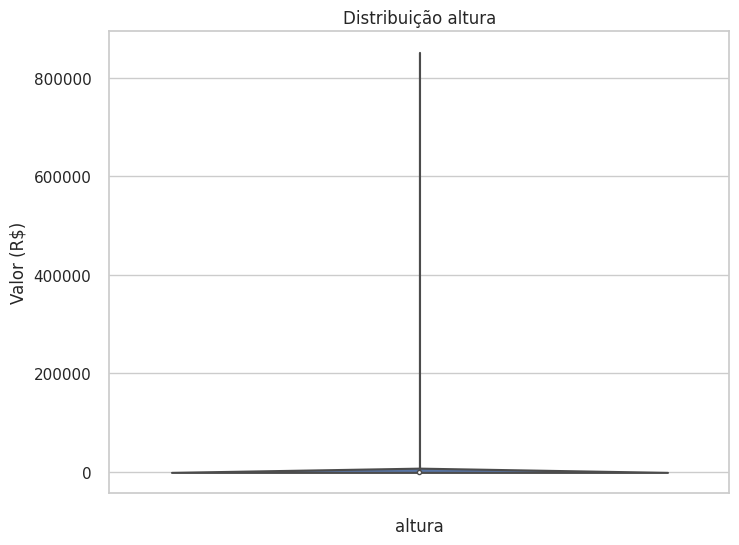

In [40]:
# Criação do gráfico de violino
sns.set(style="whitegrid")  # Estilo do gráfico

plt.figure(figsize=(8, 6))  # Tamanho da figura
sns.violinplot(y="altura", data=df1)  # Dados a serem plotados

# Adicione títulos e rótulos
plt.title("Distribuição altura")
plt.xlabel("altura")
plt.ylabel("Valor (R$)")

# Exibir o gráfico
plt.show()

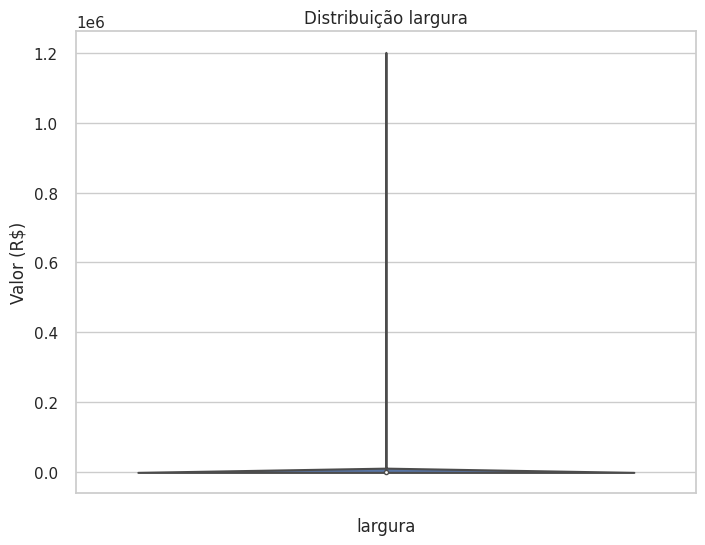

In [41]:
# Criação do gráfico de violino
sns.set(style="whitegrid")  # Estilo do gráfico

plt.figure(figsize=(8, 6))  # Tamanho da figura
sns.violinplot(y="largura", data=df1)  # Dados a serem plotados

# Adicione títulos e rótulos
plt.title("Distribuição largura")
plt.xlabel("largura")
plt.ylabel("Valor (R$)")

# Exibir o gráfico
plt.show()

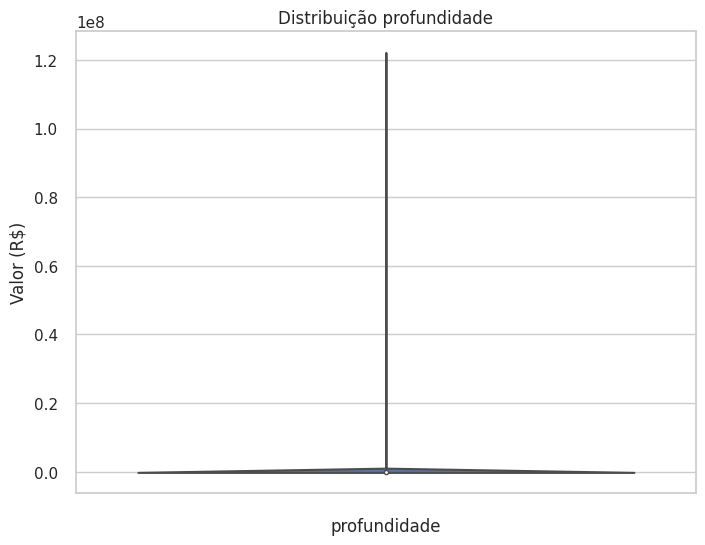

In [42]:
# Criação do gráfico de violino
sns.set(style="whitegrid")  # Estilo do gráfico

plt.figure(figsize=(8, 6))  # Tamanho da figura
sns.violinplot(y="profundidade", data=df1)  # Dados a serem plotados

# Adicione títulos e rótulos
plt.title("Distribuição profundidade")
plt.xlabel("profundidade")
plt.ylabel("Valor (R$)")

# Exibir o gráfico
plt.show()

In [14]:
# Filtro para as colunas numericas
numerical_features = df1.select_dtypes(include=['float64', 'int64']).columns

# Garantir que todo o conteúdo das colunas numéricas seja numérico
df1[numerical_features] = df1[numerical_features].apply(pd.to_numeric, errors='coerce')

#Filtro para as colunas categoricas
categorical_features = df1.select_dtypes(exclude='number').columns

# Converter as colunas categóricas para o tipo 'category'
df1[categorical_features] = df1[categorical_features].astype('category')

In [15]:
categorical_features

Index(['material', 'cor', 'categoria'], dtype='object')

In [16]:
numerical_features

Index(['valor_individual', 'altura', 'largura', 'profundidade'], dtype='object')

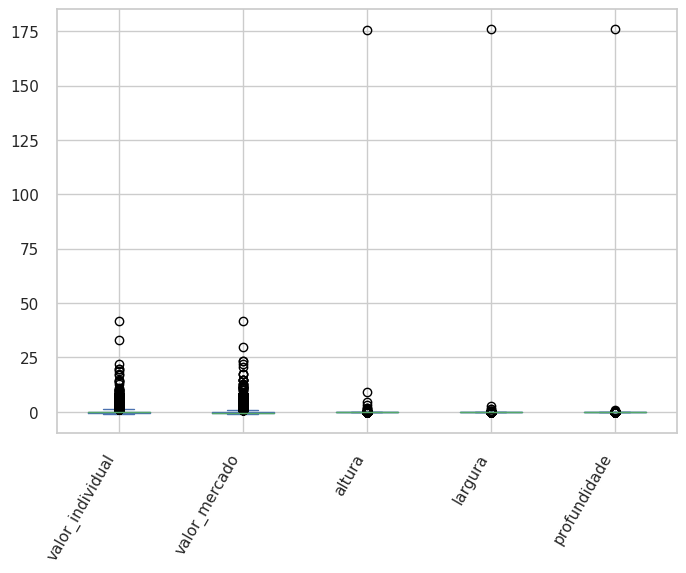

In [44]:
# Visualização de Outliers
df1[numerical_features].apply(scale).plot.box()
plt.xticks(rotation=60, ha='right');

In [38]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31674 entries, 0 to 31673
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   valor_individual  31674 non-null  float64 
 1   material          31674 non-null  category
 2   cor               31674 non-null  category
 3   categoria         31674 non-null  category
 4   altura            30876 non-null  float64 
 5   largura           30888 non-null  float64 
 6   profundidade      30944 non-null  float64 
dtypes: category(3), float64(4)
memory usage: 1.2 MB


#Remoção de Outliers

In [17]:
#len(df1.loc[df1['valor_individual']<=1000])
df1=df1[df1['valor_individual'] < df1['valor_individual'].quantile(.96)]
#df1=df1[df1['valor_mercado'] < df1['valor_mercado'].quantile(.96)]
df1=df1[df1['altura'] < df1['altura'].quantile(.95)]
df1=df1[df1['largura'] < df1['largura'].quantile(.95)]
df1=df1[df1['profundidade'] < df1['profundidade'].quantile(.95)]

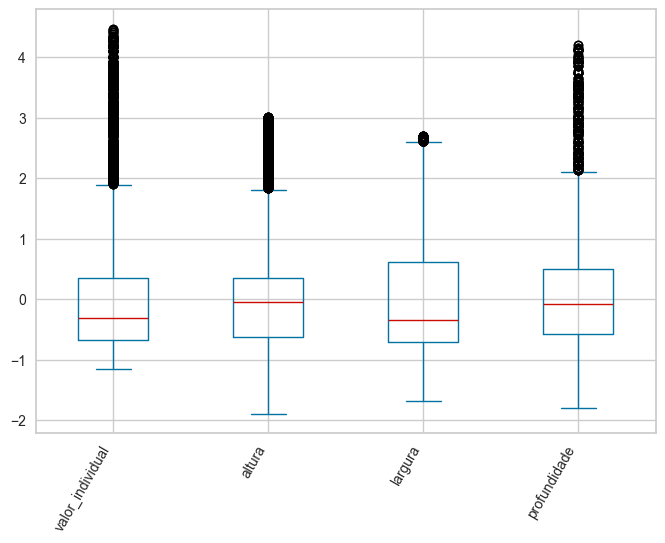

In [40]:
# Visualização de Outliers
df1[numerical_features].apply(scale).plot.box()
plt.xticks(rotation=60, ha='right');





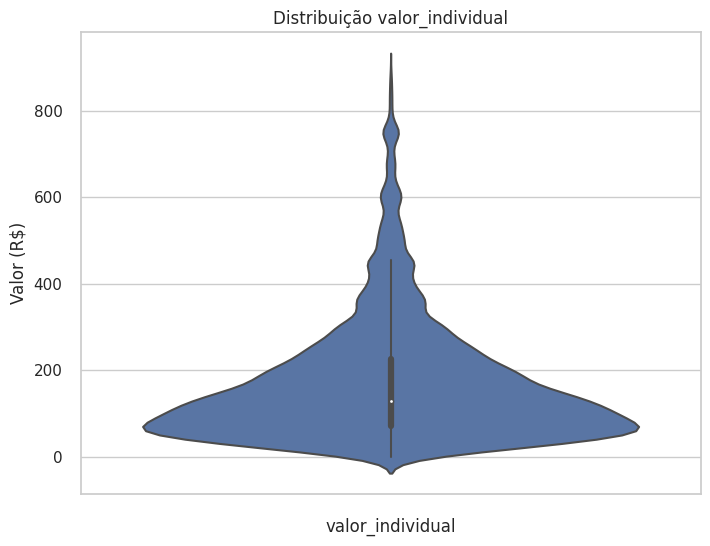

In [48]:
# Criação do gráfico de violino
sns.set(style="whitegrid")  # Estilo do gráfico

plt.figure(figsize=(8, 6))  # Tamanho da figura
sns.violinplot(y="valor_individual", data=df1)  # Dados a serem plotados

# Adicione títulos e rótulos
plt.title("Distribuição valor_individual")
plt.xlabel("valor_individual")
plt.ylabel("Valor (R$)")

# Exibir o gráfico
plt.show()

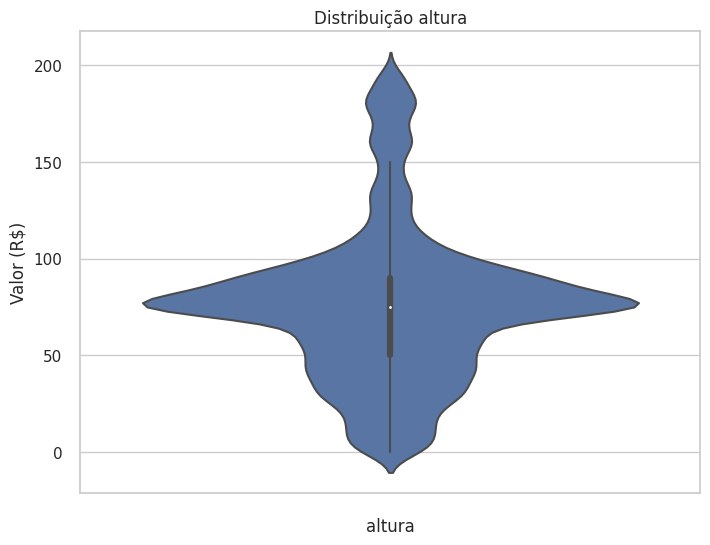

In [49]:
# Criação do gráfico de violino
sns.set(style="whitegrid")  # Estilo do gráfico

plt.figure(figsize=(8, 6))  # Tamanho da figura
sns.violinplot(y="altura", data=df1)  # Dados a serem plotados

# Adicione títulos e rótulos
plt.title("Distribuição altura")
plt.xlabel("altura")
plt.ylabel("Valor (R$)")

# Exibir o gráfico
plt.show()

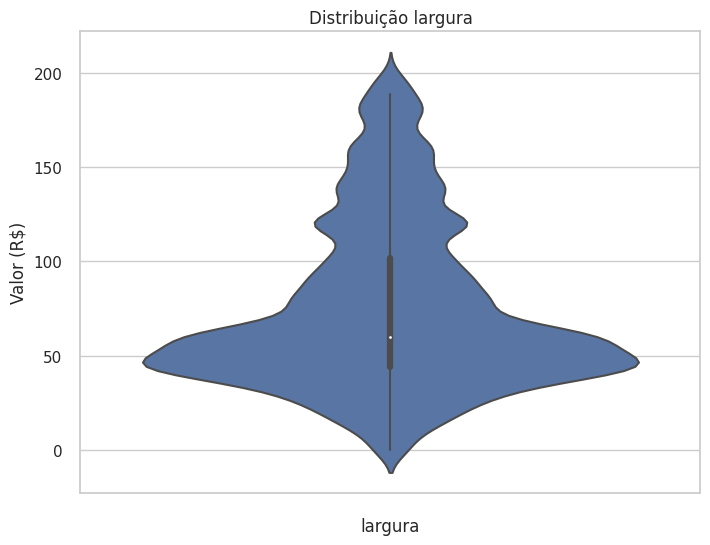

In [50]:
# Criação do gráfico de violino
sns.set(style="whitegrid")  # Estilo do gráfico

plt.figure(figsize=(8, 6))  # Tamanho da figura
sns.violinplot(y="largura", data=df1)  # Dados a serem plotados

# Adicione títulos e rótulos
plt.title("Distribuição largura")
plt.xlabel("largura")
plt.ylabel("Valor (R$)")

# Exibir o gráfico
plt.show()

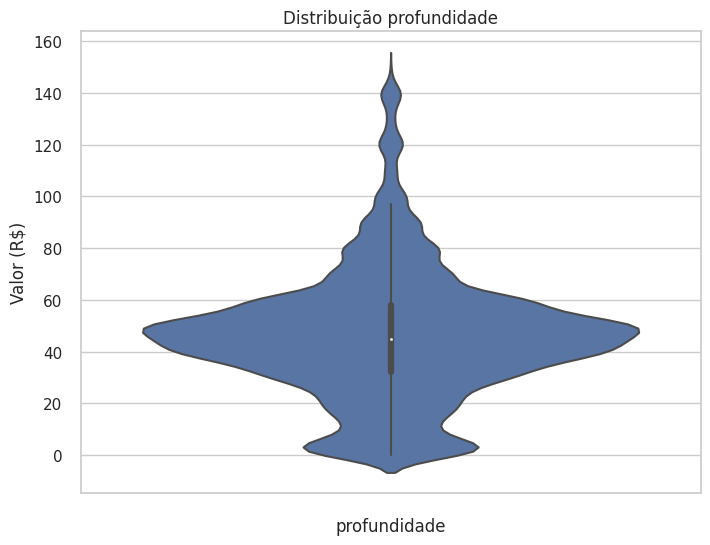

In [51]:
# Criação do gráfico de violino
sns.set(style="whitegrid")  # Estilo do gráfico

plt.figure(figsize=(8, 6))  # Tamanho da figura
sns.violinplot(y="profundidade", data=df1)  # Dados a serem plotados

# Adicione títulos e rótulos
plt.title("Distribuição profundidade")
plt.xlabel("profundidade")
plt.ylabel("Valor (R$)")

# Exibir o gráfico
plt.show()

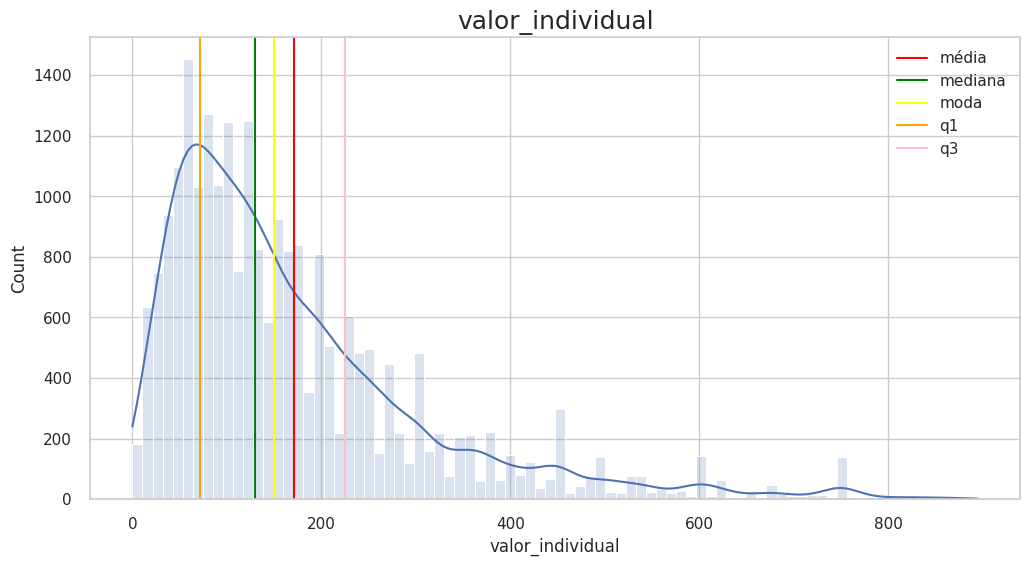

In [52]:
# Valor individual


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("valor_individual", size=18)

# Plot do Histograma
sns.histplot(df1["valor_individual"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1["valor_individual"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1["valor_individual"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1["valor_individual"].mode().shape[0]):
    plt.axvline(df1["valor_individual"].mode()[i], color="yellow", label="moda")

plt.axvline(df1["valor_individual"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1["valor_individual"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

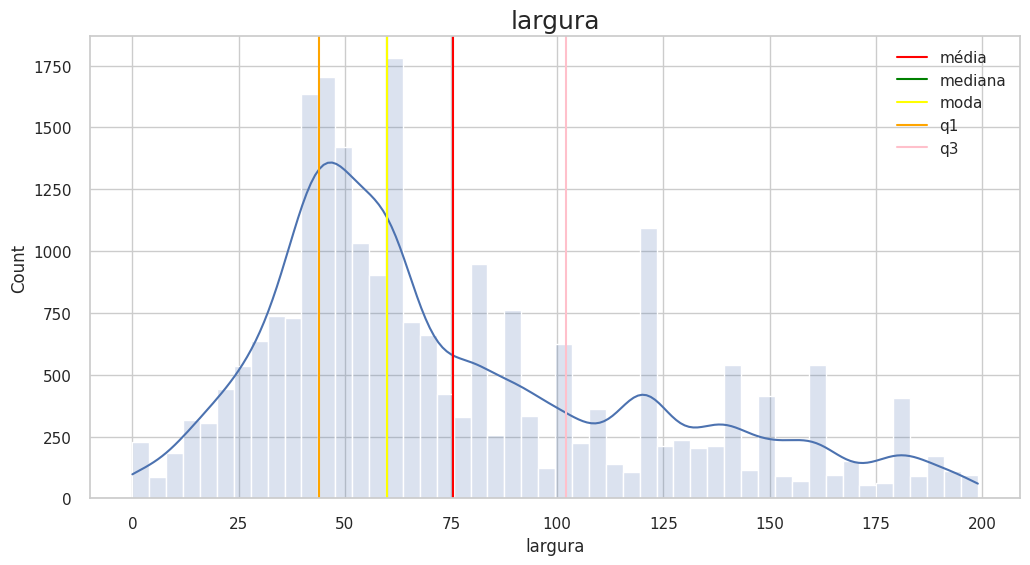

In [53]:
# largura


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("largura", size=18)

# Plot do Histograma
sns.histplot(df1["largura"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1["largura"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1["largura"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1["largura"].mode().shape[0]):
    plt.axvline(df1["largura"].mode()[i], color="yellow", label="moda")

plt.axvline(df1["largura"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1["largura"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

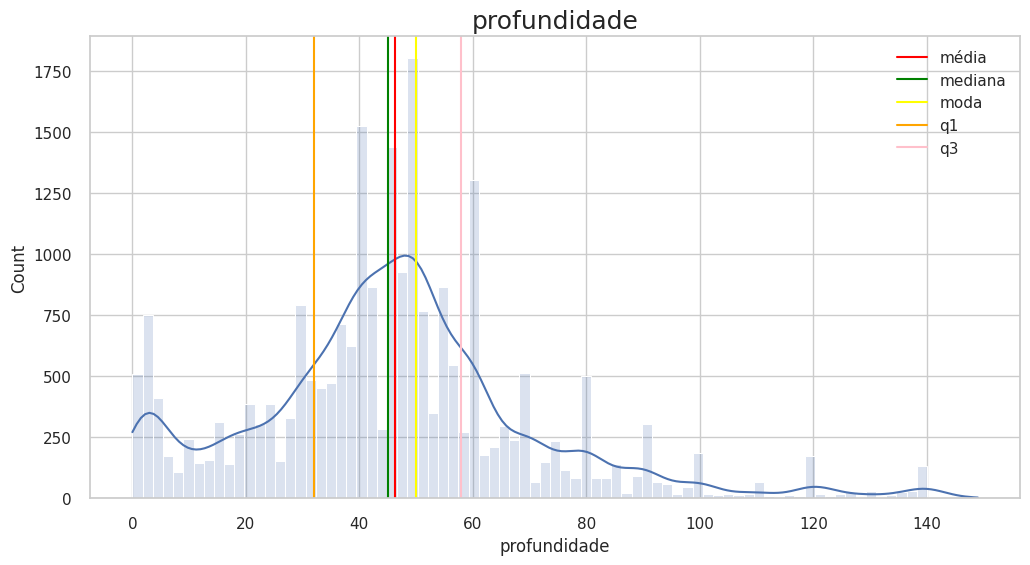

In [54]:
# profundidade


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("profundidade", size=18)

# Plot do Histograma
sns.histplot(df1["profundidade"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1["profundidade"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1["profundidade"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1["profundidade"].mode().shape[0]):
    plt.axvline(df1["profundidade"].mode()[i], color="yellow", label="moda")

plt.axvline(df1["profundidade"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1["profundidade"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

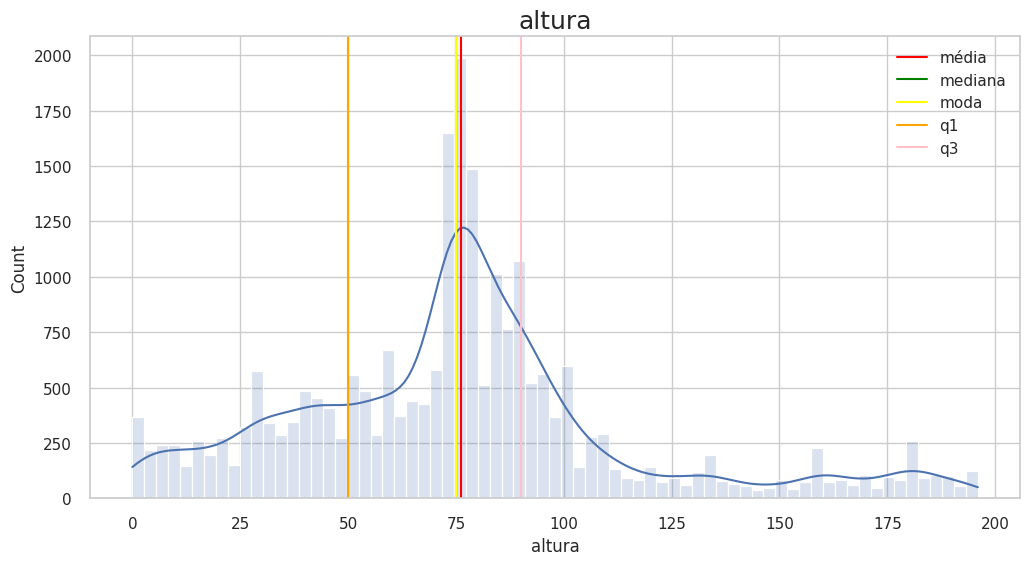

In [55]:
# altura


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("altura", size=18)

# Plot do Histograma
sns.histplot(df1["altura"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1["altura"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1["altura"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1["altura"].mode().shape[0]):
    plt.axvline(df1["altura"].mode()[i], color="yellow", label="moda")

plt.axvline(df1["altura"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1["altura"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

<Axes: xlabel='valor_mercado', ylabel='valor_individual'>

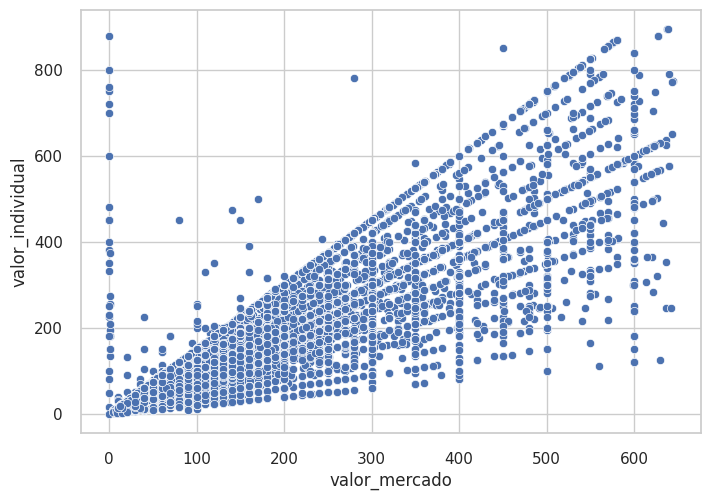

In [56]:
# sns.scatterplot(x='valor_mercado', y='valor_individual', data=df1)

In [41]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24380 entries, 0 to 31673
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   valor_individual  24380 non-null  float64 
 1   material          24380 non-null  category
 2   cor               24380 non-null  category
 3   categoria         24380 non-null  category
 4   altura            24380 non-null  float64 
 5   largura           24380 non-null  float64 
 6   profundidade      24380 non-null  float64 
dtypes: category(3), float64(4)
memory usage: 1.1 MB


In [42]:
df1.describe()

,valor_individual,altura,largura,profundidade
count,24380.000000,24380.000000,24380.000000,24380.000000
mean,183.932099,76.636998,76.323995,46.997908
std,159.814812,40.515554,45.343764,26.208051
min,0.000000,0.000000,0.000000,0.000000
25%,75.000000,51.000000,44.000000,32.000000
50%,135.000000,75.000000,61.000000,45.000000
75%,240.000000,91.000000,104.000000,60.000000
max,899.000000,199.000000,199.000000,157.000000


In [18]:
#Separando colunas
X= df1.drop(columns=['valor_individual'])
y= df1['valor_individual']

In [22]:
X.head(5)

,material,cor,categoria,altura,largura,profundidade
0,mdp,preto,mesa_de_telefone,60.0,35.0,35.0
1,mdp,marrom,aparador,71.0,33.0,29.0
2,aco,cinza,arquivo,137.0,147.0,60.0
3,metal,preto,aparelho_de_som,23.0,41.0,24.0
4,mdp,marrom,escrivaninha,73.0,78.0,57.0


In [19]:
#X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.25, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [24]:
# Listar valores únicos em X_train e X_test
unique_values_train = np.unique(X_train[['material','cor', 'categoria']])
unique_values_test = np.unique(X_test[['material','cor', 'categoria']])

# Encontrar valores únicos em X_test que não estão em X_train
values_only_in_test = np.setdiff1d(unique_values_test, unique_values_train)

# Exibir os valores únicos exclusivos em X_test
print("Valores únicos em X_test e não em X_train:")
print(values_only_in_test)

Valores únicos em X_test e não em X_train:
['amarelo_vermelho_azul' 'ambar' 'areia_bege' 'azuk' 'azul_marrom'
 'azul_preta' 'azul_rosa' 'banco_de_balanco' 'bege_e_preto'
 'branca_fosco_tauari_nobre' 'branco_brilho_com_cinza'
 'branco_transparente' 'cappuccino' 'capuccino' 'chuveiro' 'cinza_bronze'
 'dakar_branco_brilho' 'jatoba' 'laranja_e_preto'
 'legno_crema_reflecta_bronze' 'marrm' 'marrom-branco' 'marrom_(amarelo)'
 'marrom__branco' 'mel' 'modulo_para_closet' 'natura_off_white'
 'panela_de_pressao' 'receptor' 'rovere_naturale_linho_rinzai_bege'
 'saara_wood_saara_wood_cetim' 'snow_preto_onix' 'suporte_para_galao'
 'tabaco_branco' 'teka_branco' 'xadrez']


In [25]:
len(values_only_in_test)

36

COLUMN TRANSFORMER

In [21]:
#onehot encoder
#onehot = OneHotEncoder(drop = 'if_binary', handle_unknown='ignore', sparse_output=False)
onehot = OneHotEncoder(drop = 'if_binary', handle_unknown='ignore')

#preprocessador
preprocessor = ColumnTransformer([
    ('onehot', onehot, ['material','cor', 'categoria']),
 
])

preprocessor.fit(X_train, y_train)
preprocessor.transform(X_train)
preprocessor.transform(X_test)
#preprocessor.transform(X_val)

c:\Users\carlo\anaconda3\envs\pipelines\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<2438x842 sparse matrix of type '<class 'numpy.float64'>'
	with 7275 stored elements in Compressed Sparse Row format>

In [22]:
preprocessor

ColumnTransformer(transformers=[('onehot',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['material', 'cor', 'categoria'])])

In [23]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

model_pipeline.fit(X_train, y_train) 
model_pipeline.predict(X_test)
#model_pipeline.predict(X_val)
model_pipeline

c:\Users\carlo\anaconda3\envs\pipelines\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['material', 'cor',
                                                   'categoria'])])),
                ('model', DummyRegressor())])

In [24]:
model_pipeline.named_steps['model'].get_params()

{'constant': None, 'quantile': None, 'strategy': 'mean'}

In [25]:
# Defina o modelo de regressão que você deseja testar
params = {
    'model':[
    # LinearRegression(),
    #DecisionTreeRegressor(),
    #RandomForestRegressor(),
    # AdaBoostRegressor(),
    GradientBoostingRegressor(),
    #XGBRegressor()
    ]
}

# Defina as métricas de MAE e RMSE como scorers personalizados
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R2': make_scorer(r2_score)
}

# Crie o objeto GridSearchCV com as métricas personalizadas
grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring=scoring, refit='MAE', verbose=1)
grid_model.fit(X_train, y_train)

# Após a pesquisa em grade, você pode acessar os resultados do MAE e RMSE da seguinte forma:
best_model = grid_model.best_estimator_
best_mae = grid_model.best_score_
best_rmse = grid_model.cv_results_['mean_test_RMSE'][grid_model.best_index_]
best_r2 = grid_model.cv_results_['mean_test_R2'][grid_model.best_index_]

# DataFrame com os resultados da pesquisa em grade
df_cv_results = pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_MAE')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\carlo\anaconda3\envs\pipelines\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\carlo\anaconda3\envs\pipelines\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\carlo\anaconda3\envs\pipelines\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\carlo\anaconda3\envs\pipelines\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\carlo\anac

In [26]:
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_MAE,split1_test_MAE,split2_test_MAE,split3_test_MAE,...,std_test_RMSE,rank_test_RMSE,split0_test_R2,split1_test_R2,split2_test_R2,split3_test_R2,split4_test_R2,mean_test_R2,std_test_R2,rank_test_R2
0,1.225785,0.069243,0.026502,0.007172,GradientBoostingRegressor(),{'model': GradientBoostingRegressor()},96.773938,97.837705,97.176691,95.411985,...,1.383255,1,0.294909,0.308123,0.301217,0.326685,0.304119,0.307011,0.01074,1


In [27]:
# Melhores parametros
best_params = grid_model.best_params_

print("Melhores Parâmetros Encontrados:")
print(best_params)

Melhores Parâmetros Encontrados:
{'model': GradientBoostingRegressor()}


In [28]:
best_estimator = grid_model.best_estimator_

print("Melhor Estimador Encontrado:")
print(best_estimator)

Melhor Estimador Encontrado:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['material', 'cor',
                                                   'categoria'])])),
                ('model', GradientBoostingRegressor())])


In [29]:
df_cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_fit_time     1 non-null      float64
 1   std_fit_time      1 non-null      float64
 2   mean_score_time   1 non-null      float64
 3   std_score_time    1 non-null      float64
 4   param_model       1 non-null      object 
 5   params            1 non-null      object 
 6   split0_test_MAE   1 non-null      float64
 7   split1_test_MAE   1 non-null      float64
 8   split2_test_MAE   1 non-null      float64
 9   split3_test_MAE   1 non-null      float64
 10  split4_test_MAE   1 non-null      float64
 11  mean_test_MAE     1 non-null      float64
 12  std_test_MAE      1 non-null      float64
 13  rank_test_MAE     1 non-null      int32  
 14  split0_test_RMSE  1 non-null      float64
 15  split1_test_RMSE  1 non-null      float64
 16  split2_test_RMSE  1 non-null      float64
 17  s

In [30]:
df_results_mae = df_cv_results[['param_model', 'split0_test_MAE', 'split1_test_MAE', 'split2_test_MAE', 'split3_test_MAE', 'split4_test_MAE', 'mean_test_MAE', 'rank_test_MAE']]
df_results_mae

,param_model,split0_test_MAE,split1_test_MAE,split2_test_MAE,split3_test_MAE,split4_test_MAE,mean_test_MAE,rank_test_MAE
0,GradientBoostingRegressor(),96.773938,97.837705,97.176691,95.411985,96.409257,96.721915,1


In [31]:
df_results_rmse = df_cv_results[['param_model', 'split0_test_RMSE', 'split1_test_RMSE', 'split2_test_RMSE', 'split3_test_RMSE', 'split4_test_RMSE', 'mean_test_RMSE', 'rank_test_RMSE']]
df_results_rmse

,param_model,split0_test_RMSE,split1_test_RMSE,split2_test_RMSE,split3_test_RMSE,split4_test_RMSE,mean_test_RMSE,rank_test_RMSE
0,GradientBoostingRegressor(),133.576741,135.445387,132.540572,131.242516,132.819372,133.124918,1


In [32]:
df_results_R2 = df_cv_results[['param_model', 'split0_test_R2', 'split1_test_R2', 'split2_test_R2', 'split3_test_R2', 'split4_test_R2', 'mean_test_R2', 'rank_test_R2']]
df_results_R2

,param_model,split0_test_R2,split1_test_R2,split2_test_R2,split3_test_R2,split4_test_R2,mean_test_R2,rank_test_R2
0,GradientBoostingRegressor(),0.294909,0.308123,0.301217,0.326685,0.304119,0.307011,1


In [33]:
#Melhor modelo
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['material', 'cor',
                                                   'categoria'])])),
                ('model', GradientBoostingRegressor())])

Salvando melhor modelo

In [34]:
import joblib

# Salvar o modelo usando joblib
joblib.dump(best_model, 'c:/Users/carlo/OneDrive/git-repositorios/tag2u/e-commerce/pipelines/modelos/precificacao_230923_joblib_pl_sem_vm_2.pkl')

['c:/Users/carlo/OneDrive/git-repositorios/tag2u/e-commerce/pipelines/modelos/precificacao_230923_joblib_pl_sem_vm_2.pkl']

In [35]:
print(type(best_model))

<class 'sklearn.pipeline.Pipeline'>


In [59]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['material', 'cor',
                                                   'categoria'])])),
                ('model', DummyRegressor())])

In [38]:
# Obtenha as importâncias das features
gb = GradientBoostingRegressor()
modelo = gb.fit(X_train, y_train)
feature_importances = modelo.feature_importances_

# Crie uma lista de dicionários com os nomes das features e suas importâncias
feature_importance_list = [{'Feature': feature_name, 'Importance': importance} for feature_name, importance in zip(X.columns, feature_importances)]

# Crie um DataFrame a partir da lista de dicionários
feature_importance_df = pd.DataFrame(feature_importance_list)


c:\Users\carlo\anaconda3\envs\pipelines\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\carlo\anaconda3\envs\pipelines\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\carlo\anaconda3\envs\pipelines\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


ValueError: could not convert string to float: 'mdf'

 **ATÉ AQUI
 ## daqui pra baixo, ANTIGO

In [73]:
best_hyperparameters = best_model.named_steps['model'].get_params()
print("Hiperparâmetros do Melhor Modelo:")
print(best_hyperparameters)

Hiperparâmetros do Melhor Modelo:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [1]:
best_mae

NameError: name 'best_mae' is not defined

In [75]:
best_rmse

74.73743836608165

In [76]:
df_cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_MAE,split1_test_MAE,split2_test_MAE,split3_test_MAE,...,std_test_RMSE,rank_test_RMSE,split0_test_R2,split1_test_R2,split2_test_R2,split3_test_R2,split4_test_R2,mean_test_R2,std_test_R2,rank_test_R2
1,336.471453,5.282623,0.229584,0.025903,GradientBoostingRegressor(),{'model': GradientBoostingRegressor()},51.965059,53.701147,51.547926,51.945016,...,1.382934,3,0.732258,0.729369,0.725288,0.705200,0.714421,0.721307,0.010076,1
0,277.884181,4.283153,0.386602,0.066937,RandomForestRegressor(),{'model': RandomForestRegressor()},51.727507,53.135869,51.470536,51.945173,...,1.283966,1,0.726999,0.717540,0.709477,0.678593,0.719034,0.710329,0.016814,3
2,306.504290,3.129411,0.419257,0.119230,"XGBRegressor(base_score=None, booster=None, ca...","{'model': XGBRegressor(base_score=None, booste...",51.047370,53.359918,50.526162,51.193667,...,1.323164,2,0.736949,0.728673,0.722970,0.693401,0.718016,0.720002,0.014716,2


In [77]:
df_cv_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 1 to 2
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_fit_time     3 non-null      float64
 1   std_fit_time      3 non-null      float64
 2   mean_score_time   3 non-null      float64
 3   std_score_time    3 non-null      float64
 4   param_model       3 non-null      object 
 5   params            3 non-null      object 
 6   split0_test_MAE   3 non-null      float64
 7   split1_test_MAE   3 non-null      float64
 8   split2_test_MAE   3 non-null      float64
 9   split3_test_MAE   3 non-null      float64
 10  split4_test_MAE   3 non-null      float64
 11  mean_test_MAE     3 non-null      float64
 12  std_test_MAE      3 non-null      float64
 13  rank_test_MAE     3 non-null      int32  
 14  split0_test_RMSE  3 non-null      float64
 15  split1_test_RMSE  3 non-null      float64
 16  split2_test_RMSE  3 non-null      float64
 17  s

In [78]:
df_results_mae = df_cv_results[['param_model', 'split0_test_MAE', 'split1_test_MAE', 'split2_test_MAE', 'split3_test_MAE', 'split4_test_MAE', 'mean_test_MAE', 'rank_test_MAE']]
df_results_mae

,param_model,split0_test_MAE,split1_test_MAE,split2_test_MAE,split3_test_MAE,split4_test_MAE,mean_test_MAE,rank_test_MAE
1,GradientBoostingRegressor(),51.965059,53.701147,51.547926,51.945016,52.989205,52.429670,1
0,RandomForestRegressor(),51.727507,53.135869,51.470536,51.945173,51.914295,52.038676,2
2,"XGBRegressor(base_score=None, booster=None, ca...",51.047370,53.359918,50.526162,51.193667,52.109936,51.647411,3


In [79]:
df_results_rmse = df_cv_results[['param_model', 'split0_test_RMSE', 'split1_test_RMSE', 'split2_test_RMSE', 'split3_test_RMSE', 'split4_test_RMSE', 'mean_test_RMSE', 'rank_test_RMSE']]
df_results_rmse

,param_model,split0_test_RMSE,split1_test_RMSE,split2_test_RMSE,split3_test_RMSE,split4_test_RMSE,mean_test_RMSE,rank_test_RMSE
1,GradientBoostingRegressor(),73.365292,76.363378,73.966302,73.528529,76.463692,74.737438,3
0,RandomForestRegressor(),74.082278,78.014366,76.065023,76.775021,75.843700,76.156078,1
2,"XGBRegressor(base_score=None, booster=None, ca...",72.719718,76.461546,74.277677,74.985586,75.980864,74.885078,2


In [80]:
df_results_R2 = df_cv_results[['param_model', 'split0_test_R2', 'split1_test_R2', 'split2_test_R2', 'split3_test_R2', 'split4_test_R2', 'mean_test_R2', 'rank_test_R2']]
df_results_R2

,param_model,split0_test_R2,split1_test_R2,split2_test_R2,split3_test_R2,split4_test_R2,mean_test_R2,rank_test_R2
1,GradientBoostingRegressor(),0.732258,0.729369,0.725288,0.705200,0.714421,0.721307,1
0,RandomForestRegressor(),0.726999,0.717540,0.709477,0.678593,0.719034,0.710329,3
2,"XGBRegressor(base_score=None, booster=None, ca...",0.736949,0.728673,0.722970,0.693401,0.718016,0.720002,2


Melhor modelo para MAE: XGBRegressor()

Melhor modelo para RMSE: GradientBoostingRegressor()

Melhor modelo para R2: GradientBoostingRegressor()


Otimizando  GradientBoostingRegressor()

In [81]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor())
])

params ={
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3,4,5],
    'model__n_estimators':[300,400,500],
    'model__subsample':[1., .8]

}

In [ ]:
# Defina as métricas de MAE e RMSE como scorers personalizados
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R2': make_scorer(r2_score)
}

# Crie o objeto GridSearchCV com as métricas personalizadas
grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring=scoring, refit='MAE', n_jobs=-1, verbose=1)
grid_model.fit(X_train, y_train)

# Após a pesquisa em grade, você pode acessar os resultados do MAE e RMSE da seguinte forma:
best_model = grid_model.best_estimator_
best_mae = grid_model.best_score_
best_rmse = grid_model.cv_results_['mean_test_RMSE'][grid_model.best_index_]
best_r2 = grid_model.cv_results_['mean_test_R2'][grid_model.best_index_]

# DataFrame com os resultados da pesquisa em grade
df_cv_gb_results = pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_MAE')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
df_cv_gb_results

Otimizando o  XGBRegressor()

In [ ]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
])

params ={
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3,4,5],
    'model__n_estimators':[300,400,500],
    'model__subsample':[1., .8]


In [ ]:
# Defina as métricas de MAE e RMSE como scorers personalizados
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R2': make_scorer(r2_score)
}

# Crie o objeto GridSearchCV com as métricas personalizadas
grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring=scoring, refit='MAE', n_jobs=-1, verbose=1)
grid_model.fit(X_train, y_train)

# Após a pesquisa em grade, você pode acessar os resultados do MAE e RMSE da seguinte forma:
best_model = grid_model.best_estimator_
best_mae = grid_model.best_score_
best_rmse = grid_model.cv_results_['mean_test_RMSE'][grid_model.best_index_]
best_r2 = grid_model.cv_results_['mean_test_R2'][grid_model.best_index_]

# DataFrame com os resultados da pesquisa em grade
df_cv_xgb_results = pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_MAE')

outros

In [ ]:
params = {
    'model':[
    #LinearRegression(),
    #DecisionTreeRegressor(),
    RandomForestRegressor(),
    #AdaBoostRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor()
    ]

}

grid_model=GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202:

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['material',
                                                                          'cor',
                                                                          'categoria',
                                                                          'titulo']),
                                                                        ('std_scaler',
                                                                         StandardScaler(),
                                                                         ['valor_mercado',
                                                                          'altura',
                                                                          'largura',
                                                                          'profundidade'])])),
                                       ('model', DummyRegressor())]),
             param_grid={'mo...
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_bin=None,
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=None,
                                                max_delta_step=None,
                                                max_depth=None, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estimators=100, n_jobs=None,
                                                num_parallel_tree=None,
                                                predictor=None,
                                                random_state=None, ...)]},
             scoring='r2', verbose=1)

In [ ]:
model_pipeline.fit(X_train, y_train)

In [ ]:
def get_metrics(y_true, y_pred):
  dict_metrics ={
      'R2': metrics.r2_score(y_true, y_pred),
      'MAE': metrics.mean_absolute_error(y_true, y_pred),
      'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
      'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
  }

  return dict_metrics

In [ ]:
get_metrics(y_true, y_pred)

NameError: ignored

In [ ]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gb_model', GradientBoostingRegressor())
])

model_pipeline.fit(X_train, y_train)



In [ ]:
model_pipeline.predict(X_test)

In [ ]:
# transformações em df5 Standard Scaler

# 1. Separar os recursos (features) e o alvo (target)
X5 = df5[variaveis]
y5 = df5[alvo]

# 2. Aplicar a Standard Scaler
std_scaler = StandardScaler()
numeric_features = X5.select_dtypes(include=[np.number]).columns.tolist()
X5[numeric_features] = std_scaler.fit_transform(X5[numeric_features])

In [ ]:
preprocessor = ColumnTransformer([
    #material
    le.fit(df1.material)
    df1.material = le.transform(df1.material)

    # cor
    le.fit(df1.cor)
    df1.cor = le.transform(df1.cor)

    #categoria
    le.fit(df1.categoria)
    df1.categoria = le.transform(df1.categoria)

    #titulo
    le.fit(df1.titulo)
    df1.titulo = le.transform(df1.titulo)
    ])

SyntaxError: ignored

antigo

In [ ]:
df1[categorical_features]

,material,cor,categoria,titulo
0,mdp,preto,mesa_de_telefone,mesa_de_telefone
1,mdp,marrom,aparador,aparador
2,aco,cinza,arquivo,arquivo_c_4_gavetas
3,metal,preto,aparelho_de_som,aparelho_de_som
4,mdp,marrom,escrivaninha,mesa_de_computador
...,...,...,...,...
31795,plastico,branco,ventilador,ventilador_pedestal
31796,madeira,cinza,cabeceira,cabeceira_queen_size
31797,metal,branco,microondas,microondas_20_litros
31798,ceramica,amarelo,vaso,vaso


In [ ]:
le = LabelEncoder()

#material
le.fit(df1.material)
df1.material = le.transform(df1.material)

# cor
le.fit(df1.cor)
df1.cor = le.transform(df1.cor)

#categoria
le.fit(df1.categoria)
df1.categoria = le.transform(df1.categoria)

#titulo
le.fit(df1.titulo)
df1.titulo = le.transform(df1.titulo)

#SKU
#le.fit(df1.sku)
#df1.sku = le.transform(df1.sku)


#classificacao
#le.fit(df1.classificacao)
#df1.classificacao = le.transform(df1.classificacao)

In [ ]:
df1[categorical_features]

,material,cor,categoria,titulo
0,27,452,216,7617
1,27,360,5,108
2,0,227,18,1325
3,28,452,8,296
4,27,360,130,6942
...,...,...,...,...
31795,34,103,330,10480
31796,24,227,48,2123
31797,28,103,218,7853
31798,8,12,329,10403


In [ ]:
df1.describe()

,valor_individual,valormercado,material,cor,categoria,titulo,altura,largura,profundidade
count,24479.000000,24479.000000,24479.000000,24479.000000,24479.000000,24479.000000,24479.000000,24479.000000,24479.000000
mean,183.794398,192.023251,27.366110,267.972507,146.233465,5062.873483,76.628784,76.290249,46.936966
std,159.832770,171.074945,8.375948,153.355309,97.044175,2976.716174,40.530158,45.315539,26.217495
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,90.000000,24.000000,103.000000,52.000000,2327.000000,51.000000,44.000000,32.000000
50%,135.000000,150.000000,27.000000,277.000000,159.000000,5142.000000,75.000000,61.000000,45.000000
75%,240.000000,234.000000,33.000000,451.000000,213.000000,7439.500000,91.000000,104.000000,59.000000
max,899.000000,2200.000000,46.000000,498.000000,332.000000,10511.000000,199.000000,199.000000,157.000000


<Axes: >

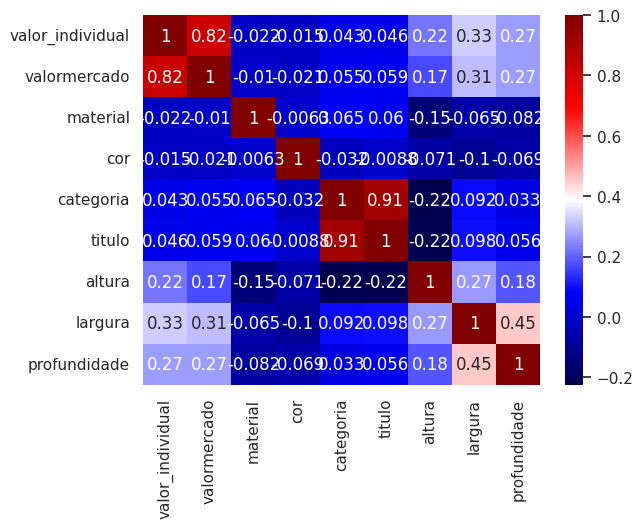

In [ ]:
sns.heatmap(df1.corr(), annot=True, cmap='seismic')

In [ ]:
df3 = df1.copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24479 entries, 0 to 31799
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_individual  24479 non-null  float64
 1   valormercado      24479 non-null  float64
 2   material          24479 non-null  int64  
 3   cor               24479 non-null  int64  
 4   categoria         24479 non-null  int64  
 5   titulo            24479 non-null  int64  
 6   altura            24479 non-null  float64
 7   largura           24479 non-null  float64
 8   profundidade      24479 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 1.9 MB


In [ ]:
df3.isnull().sum()

valor_individual    0
valormercado        0
material            0
cor                 0
categoria           0
titulo              0
altura              0
largura             0
profundidade        0
dtype: int64

In [ ]:
df3.describe()

,valor_individual,valormercado,material,cor,categoria,titulo,altura,largura,profundidade
count,24479.000000,24479.000000,24479.000000,24479.000000,24479.000000,24479.000000,24479.000000,24479.000000,24479.000000
mean,183.794398,192.023251,27.366110,267.972507,146.233465,5062.873483,76.628784,76.290249,46.936966
std,159.832770,171.074945,8.375948,153.355309,97.044175,2976.716174,40.530158,45.315539,26.217495
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,90.000000,24.000000,103.000000,52.000000,2327.000000,51.000000,44.000000,32.000000
50%,135.000000,150.000000,27.000000,277.000000,159.000000,5142.000000,75.000000,61.000000,45.000000
75%,240.000000,234.000000,33.000000,451.000000,213.000000,7439.500000,91.000000,104.000000,59.000000
max,899.000000,2200.000000,46.000000,498.000000,332.000000,10511.000000,199.000000,199.000000,157.000000


In [ ]:
#Para Standard Scale =>df5
df5 = df3.copy()

In [ ]:
#Separacao de variaveis
variaveis =  ['valormercado', 'material', 'cor','categoria', 'titulo', 'altura', 'largura', 'profundidade']
alvo = ['valor_individual']

In [ ]:
# transformações em df5 Standard Scaler

# 1. Separar os recursos (features) e o alvo (target)
X5 = df5[variaveis]
y5 = df5[alvo]

# 2. Aplicar a Standard Scaler
std_scaler = StandardScaler()
numeric_features = X5.select_dtypes(include=[np.number]).columns.tolist()
X5[numeric_features] = std_scaler.fit_transform(X5[numeric_features])

<ipython-input-59-2003b563e401>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X5[numeric_features] = std_scaler.fit_transform(X5[numeric_features])


In [ ]:
X5.describe()

,valormercado,material,cor,categoria,titulo,altura,largura,profundidade
count,2.447900e+04,2.447900e+04,2.447900e+04,2.447900e+04,2.447900e+04,2.447900e+04,2.447900e+04,2.447900e+04
mean,7.895242e-17,3.831514e-17,-2.670449e-17,1.352641e-16,-8.475774e-17,-3.715408e-17,1.323614e-16,-5.747272e-17
std,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00
min,-1.122474e+00,-3.267292e+00,-1.747432e+00,-1.506906e+00,-1.700860e+00,-1.890700e+00,-1.683568e+00,-1.790328e+00
25%,-5.963780e-01,-4.018863e-01,-1.075775e+00,-9.710566e-01,-9.191099e-01,-6.323515e-01,-7.125791e-01,-5.697444e-01
50%,-2.456474e-01,-4.371054e-02,5.886772e-02,1.315565e-01,2.658236e-02,-4.018778e-02,-3.374242e-01,-7.388219e-02
75%,2.453755e-01,6.726409e-01,1.193511e+00,6.880155e-01,7.984218e-01,3.545881e-01,6.114970e-01,4.601233e-01
max,1.173765e+01,2.224736e+00,1.499995e+00,1.914286e+00,1.830285e+00,3.019325e+00,2.707951e+00,4.198162e+00


#Seleção de Variáveis - df5

In [ ]:
# Variáveis selecionadas para df5:  material+cor+categoria+altura+largura+profundidade
variaveis_5 = ['valormercado', 'cor', 'categoria', 'altura', 'largura', 'profundidade']
X5_5 = X5[variaveis_5]

In [ ]:
X5_5.describe()

,valormercado,cor,categoria,altura,largura,profundidade
count,2.447900e+04,2.447900e+04,2.447900e+04,2.447900e+04,2.447900e+04,2.447900e+04
mean,7.895242e-17,-2.670449e-17,1.352641e-16,-3.715408e-17,1.323614e-16,-5.747272e-17
std,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00
min,-1.122474e+00,-1.747432e+00,-1.506906e+00,-1.890700e+00,-1.683568e+00,-1.790328e+00
25%,-5.963780e-01,-1.075775e+00,-9.710566e-01,-6.323515e-01,-7.125791e-01,-5.697444e-01
50%,-2.456474e-01,5.886772e-02,1.315565e-01,-4.018778e-02,-3.374242e-01,-7.388219e-02
75%,2.453755e-01,1.193511e+00,6.880155e-01,3.545881e-01,6.114970e-01,4.601233e-01
max,1.173765e+01,1.499995e+00,1.914286e+00,3.019325e+00,2.707951e+00,4.198162e+00


In [ ]:
#Criando um novo df
df5_5 = pd.concat([X5_5, y5], axis=1)

GradientBoostingRegressor(random_state=8555)

#Modelando



In [ ]:
#Função para o cálculo de R2-ajustado
def adjusted_r2(y_test, y_pred, X_selecionado_train):
    adj_r2 = (1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1)) /
              (len(y_test) - X_selecionado_train.shape[1] - 1))
    return adj_r2

In [ ]:
#K-Fold
from sklearn.model_selection import cross_val_score

def modelo_kfold(X, y, n_splits=5, random_state=8555):

    modelo = GradientBoostingRegressor(random_state=8555)

    lista_metricas_kfold = []

    estimador_base = modelo

    # Perform k-fold cross-validation

    #define cross-validation method to use
    cv = KFold(n_splits=10, random_state=0, shuffle=True)

    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
    scores = cross_validate(estimador_base, X, y, cv=cv, scoring=scoring, return_train_score=True)

    # Calculate adjusted R² for both train and test sets
    n = len(X)
    p = X.shape[1]  # Number of features
    adj_r2_train = 1 - ((1 - np.mean(scores['train_r2'])) * (n - 1)) / (n - p - 1)
    adj_r2_test = 1 - ((1 - np.mean(scores['test_r2'])) * (n - 1)) / (n - p - 1)

    metrics_dict_kfold = {
        'Modelo': str(modelo),
        'R2 Train': np.mean(scores['train_r2']),
        'R2 Test': np.mean(scores['test_r2']),
        'R2 Adj Train': adj_r2_train,
        'R2 Adj Test': adj_r2_test,
        'MAE train': -np.mean(scores['train_neg_mean_absolute_error']),
        'MAE test': -np.mean(scores['test_neg_mean_absolute_error']),
        'MSE train': -np.mean(scores['train_neg_mean_squared_error']),
        'MSE test': -np.mean(scores['test_neg_mean_squared_error']),
        'RMSE train': np.sqrt(-np.mean(scores['train_neg_mean_squared_error'])),
        'RMSE test': np.sqrt(-np.mean(scores['test_neg_mean_squared_error']))
        }

    lista_metricas_kfold.append(metrics_dict_kfold)

    return lista_metricas_kfold

**cenário** : Abordagem Standard Scale

In [ ]:
# 2. Avaliando o modelo e exibindo o DataFrame
cenario = modelo_kfold(X5_5, y5, n_splits=5, random_state=8555)
cen_10 =  pd.DataFrame(cenario)
cen_10['cenario'] = 'cen_10'
cen_10

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

,Modelo,R2 Train,R2 Test,R2 Adj Train,R2 Adj Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test,cenario
0,GradientBoostingRegressor(random_state=8555),0.774314,0.761705,0.774259,0.761647,53.247357,54.188294,5765.076631,6071.684047,75.928102,77.921012,cen_10


In [ ]:
import pickle
pickle dump()
with open('../models/model.pkl',as 'wb') as file_model:
        pickle.dump(model_pipeline, file_model)

In [ ]:
import pickle
pickle dump()
with open('/content/drive/MyDrive/Colab Notebooks/DNC/Projeto TAG2u/trabalho/modelagem/implantacao/modelo/modelo_2023-09-01_1.pkl',as 'wb')as file_model:
  pickle.dump(model_pipeline, file_model)


SyntaxError: ignored